<a href="https://colab.research.google.com/github/RicardoMourao-py/INFORMACOES_GEORREFERENCIADAS/blob/main/projeto_infogeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalando bibliotecas

In [1]:
!pip install geopandas --quiet
!pip install geopy --quiet
!pip install pointpats==2.3.0 --quiet
!pip install fiona --quiet
!pip install seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.9 MB/s eta 0:00:00


## Importando Bibliotecas

In [2]:
import geopandas as gpd
import fiona as f
from pointpats import PointPattern
import matplotlib.pyplot as plt
import os
import numpy as np
from pointpats.centrography import mean_center, weighted_mean_center, std_distance, ellipse
from matplotlib.patches import Ellipse
from pointpats import hull
import pointpats.quadrat_statistics as qs
import seaborn as sns
import math
from pointpats.distance_statistics import K
from pointpats import PoissonPointProcess
import itertools
from pointpats.distance_statistics import Kenv
from google.colab import files

## Equipamento Esporte

In [3]:
equip_esporte_clube = gpd.read_file("SIRGAS_GPKG_TEMA_ESPORTE_CLUBE.gpkg")
equip_esporte_clube_comunidade = gpd.read_file("SIRGAS_GPKG_TEMA_ESPORTE_CLUBE DA COMUNIDADE.gpkg")
equip_esporte_centro_esportivo = gpd.read_file("SIRGAS_GPKG_TEMA_ESPORTE_CENTRO ESPORTIVO.gpkg")
equip_esporte_estadio = gpd.read_file("SIRGAS_GPKG_TEMA_ESPORTE_ESTADIO.gpkg")
equip_esporte_outros = gpd.read_file("SIRGAS_GPKG_TEMA_ESPORTE_OUTROS.gpkg")
distritos = gpd.read_file("distritos-sp.geojson")

In [4]:
distritos.head(1)

,primaryind,ds_codigo,ds_subpref,ds_cd_sub,ds_sigla,ds_nome,geometry
0,1.0,63,PIRITUBA-JARAGUA,02,PIR,PIRITUBA,"MULTIPOLYGON (((-46.71217 -23.45452, -46.7122 ..."


In [5]:
equip_esporte_clube.head(1)

,eq_nome,eq_bairro,eq_cep,eq_cd_tipo,eq_tipo,eq_enderec,eq_cd_esfe,eq_classe,eq_rede,eq_cd_tema,geometry
0,CENTRO ESPORTIVO TIETÊ,LUZ,1101000,9,9,"AV SANTOS DUMONT, 843",PÚBLICO - MUNICIPAL,CLUBE,SEM REDE,5,POINT (333498.8 7397872.72)


In [6]:
equip_esporte_clube_comunidade.head(1)

,eq_nome,eq_bairro,eq_cep,eq_cd_tipo,eq_tipo,eq_enderec,eq_cd_esfe,eq_classe,eq_rede,eq_cd_tema,geometry
0,CDC UNIÃO PARQUE SÃO RAFAEL,SÃO RAFAEL,8310490,11,11,"RUA FREI MATEUS DE ASSUNÇÃO, S/N",PÚBLICO - MUNICIPAL,CLUBE DA COMUNIDADE,SEM REDE,5,POINT (349790.13 7386446.49)


In [7]:
equip_esporte_centro_esportivo.head(1)

,eq_nome,eq_bairro,eq_cep,eq_cd_tipo,eq_tipo,eq_enderec,eq_cd_esfe,eq_classe,eq_rede,eq_cd_tema,geometry
0,GINÁSIO ESPORTIVO DARCY REIS,VILA GUILHERME,2053003,1,1,"AV GUILHERME, 1819",PÚBLICO - MUNICIPAL,CENTRO ESPORTIVO,SEM REDE,5,POINT (336647.3 7399338.16)


In [8]:
equip_esporte_estadio.head(1)

,eq_nome,eq_bairro,eq_cep,eq_cd_tipo,eq_tipo,eq_enderec,eq_cd_esfe,eq_classe,eq_rede,eq_cd_tema,geometry
0,ESTÁDIO MUNICIPAL JACK MARIN,ACLIMAÇÃO,1534001,8,8,"R MUNIZ DE SOUSA, 1119",PÚBLICO - MUNICIPAL,ESTADIO,SEM REDE,5,POINT (333877.77 7392070.01)


In [9]:
equip_esporte_outros.head(1)

,eq_nome,eq_bairro,eq_cep,eq_cd_tipo,eq_tipo,eq_enderec,eq_cd_esfe,eq_classe,eq_rede,eq_cd_tema,geometry
0,CENTRO OLÍMPICO DE TREINAMENTO E PESQUISA,INDIANÓPOLIS,4028001,5,5,"AV IBIRAPUERA, 1315",PÚBLICO - MUNICIPAL,OUTROS,SEM REDE,5,POINT (331002.27 7389264.75)


In [10]:
equip_esporte_clube.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

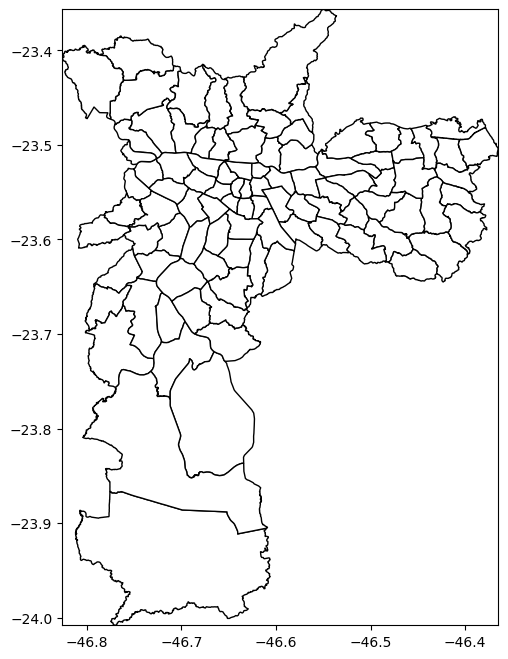

In [13]:
fig, ax = plt.subplots(figsize=(10,8))

# Plotando o mapa dos distritos
distritos.plot(ax=ax, color='white', edgecolor='k')

# Plotando os equipamentos esportivos no mesmo ax
equip_esporte_clube.plot(ax=ax, color='gray', edgecolor='k')

# Garantindo que ambos os plots usem os mesmos limites de eixos
ax.set_xlim(distritos.total_bounds[[0, 2]])  # Definindo limites no eixo x
ax.set_ylim(distritos.total_bounds[[1, 3]])  # Definindo limites no eixo y

plt.show()

Index(['ad_enderec', 'ad_prog', 'ad_site', 'ad_unidade', 'ad_agenda',
       'ad_contato', 'ad_detalhe', 'ad_horario', 'geometry'],
      dtype='object')

## Equipamento Bom Prato

In [15]:
# Votos para o Brexit
!wget --no-check-certificate https://repositorio.seade.gov.br/dataset/ba6b40e3-9bfe-4bb6-a741-d9436b0312a2/resource/4cd70073-7a54-4116-bbfb-552764e385f7/download/bomprato.zip

--2024-10-24 21:38:55--  https://repositorio.seade.gov.br/dataset/ba6b40e3-9bfe-4bb6-a741-d9436b0312a2/resource/4cd70073-7a54-4116-bbfb-552764e385f7/download/bomprato.zip
Resolving repositorio.seade.gov.br (repositorio.seade.gov.br)... 201.55.54.161
Connecting to repositorio.seade.gov.br (repositorio.seade.gov.br)|201.55.54.161|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 16306 (16K) [application/zip]
Saving to: ‘bomprato.zip’

bomprato.zip        100%[===================>]  15.92K  --.-KB/s    in 0s      

2024-10-24 21:38:56 (197 MB/s) - ‘bomprato.zip’ saved [16306/16306]



In [16]:
# prompt: unzip

!unzip bomprato.zip


Archive:  bomprato.zip
 extracting: Bomprato.cpg            
  inflating: Bomprato.dbf            
  inflating: Bomprato.prj            
  inflating: Bomprato.qmd            
  inflating: Bomprato.shp            
  inflating: Bomprato.shx            
  inflating: Bomprato.xlsx           


In [17]:
bom_prato = gpd.read_file('Bomprato.shp')

In [21]:
bom_prato.head(5)

,Item,tipo,endereco,municipio,regiao,lat,long,geometry
0,16,BP_FIXO,"Avenida Antônio Sylvio Cunha Bueno, 1904",Diadema,RMPS,-23.722221,-46.616250,POINT (-46.61625 -23.72222)
1,46,BP_FIXO,"Rua Dr. Arnaldo Miraglia, nº quadra 06",Bauru,interior,-22.314090,-49.123995,POINT (-49.12399 -22.31409)
2,47,BP_FIXO,"Rua Mauá, 66",São Paulo,Capital,-23.535079,-46.639350,POINT (-46.63935 -23.53508)
3,66,BP_FIXO,"ETECRI México 70 - Rua do Canal, 582 - Vila Ma...",São Vicente,interior,-23.973035,-46.405382,POINT (-46.40538 -23.97304)
4,67,BP_FIXO,"Praça Nossa Senhora Aparecida, Vila Nossa Senh...",São Vicente,interior,-23.973035,-46.403922,POINT (-46.40392 -23.97304)


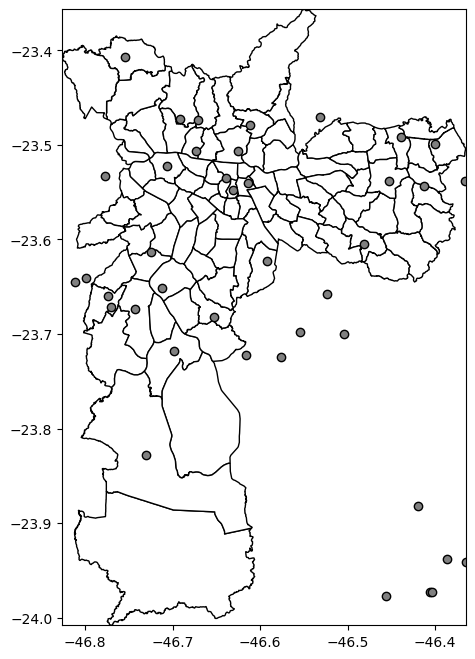

In [20]:
fig, ax = plt.subplots(figsize=(10,8))

# Plotando o mapa dos distritos
distritos.plot(ax=ax, color='white', edgecolor='k')

# Plotando os equipamentos esportivos no mesmo ax
bom_prato.plot(ax=ax, color='gray', edgecolor='k')

# Garantindo que ambos os plots usem os mesmos limites de eixos
ax.set_xlim(distritos.total_bounds[[0, 2]])  # Definindo limites no eixo x
ax.set_ylim(distritos.total_bounds[[1, 3]])  # Definindo limites no eixo y

plt.show()

## Cadastro Único

In [23]:
!wget --no-check-certificate https://repositorio.seade.gov.br/dataset/7bb1a33a-7600-42fd-ad4d-33e9d4734a37/resource/6913ebd1-3518-47d1-abbd-2b6ce30152ce/download/ppa_oe04_ge203.zip

--2024-10-24 22:04:38--  https://repositorio.seade.gov.br/dataset/7bb1a33a-7600-42fd-ad4d-33e9d4734a37/resource/6913ebd1-3518-47d1-abbd-2b6ce30152ce/download/ppa_oe04_ge203.zip
Resolving repositorio.seade.gov.br (repositorio.seade.gov.br)... 201.55.54.161
Connecting to repositorio.seade.gov.br (repositorio.seade.gov.br)|201.55.54.161|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 20727073 (20M) [application/zip]
Saving to: ‘ppa_oe04_ge203.zip’

ppa_oe04_ge203.zip  100%[===================>]  19.77M  2.90MB/s    in 8.6s    

2024-10-24 22:04:48 (2.31 MB/s) - ‘ppa_oe04_ge203.zip’ saved [20727073/20727073]



In [24]:
!unzip ppa_oe04_ge203.zip

Archive:  ppa_oe04_ge203.zip
  inflating: PPA_OE04_ge203.xlsx     
  inflating: PPA_OE04_ge203.cpg      
  inflating: PPA_OE04_ge203.dbf      
  inflating: PPA_OE04_ge203.prj      
  inflating: PPA_OE04_ge203.qmd      
  inflating: PPA_OE04_ge203.shp      
  inflating: PPA_OE04_ge203.shx      


In [25]:
cad_unico = gpd.read_file('PPA_OE04_ge203.shp')

In [26]:
cad_unico

,Cod_ibge,Municipio,de201,ge101,ge107,ge116,ge201,ge202,ge203,in101,in201,ra101,ra102,ra103,sn0103,sn0104,geometry
0,3509908,Cananéia,24.1,1.7,15,85.3,508.1,0.0,77.6,48.8,0.0,1145,780,117,85.2,30.9,"POLYGON ((-47.83033 -24.75638, -47.83013 -24.7..."
1,3520426,Ilha Comprida,21.1,2.7,5,70.7,496.0,0.0,66.4,65.2,7.9,1125,735,158,60.0,NaN,"POLYGON ((-47.4366 -24.67434, -47.43638 -24.67..."
2,3505401,Barra do Turvo,17.5,1.6,0,76.3,202.0,0.0,75.6,55.8,9.0,485,279,33,94.8,90.2,"POLYGON ((-48.44457 -24.65134, -48.44418 -24.6..."
3,3509254,Cajati,9.2,2.3,61,60.5,355.5,0.0,72.2,65.6,0.0,6448,2842,226,83.2,274.9,"POLYGON ((-48.1556 -24.64078, -48.15505 -24.64..."
4,3524600,Jacupiranga,5.6,1.4,21,71.0,343.8,0.0,76.6,53.7,0.0,2962,1970,216,93.9,0.0,"POLYGON ((-48.00104 -24.5716, -48.0004 -24.572..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,3530003,Mira Estrela,0.0,3.7,0,8.8,385.7,0.0,54.1,70.0,0.0,277,171,8,100.0,25.0,"POLYGON ((-50.10224 -19.87441, -50.09732 -19.8..."
641,3520707,Indiaporã,0.0,2.3,0,9.5,311.4,0.0,60.9,67.9,0.0,382,223,7,97.8,400.0,"POLYGON ((-50.20045 -19.86626, -50.19701 -19.8..."
642,3529658,Mesópolis,0.0,2.8,0,7.9,293.5,0.0,60.3,75.0,0.0,116,69,0,98.2,37.0,"POLYGON ((-50.61347 -19.86537, -50.61346 -19.8..."
643,3534757,Ouroeste,11.1,2.6,6,13.1,282.3,0.0,55.0,77.6,0.0,2045,639,26,100.0,228.0,"POLYGON ((-50.44955 -19.78895, -50.44771 -19.7..."


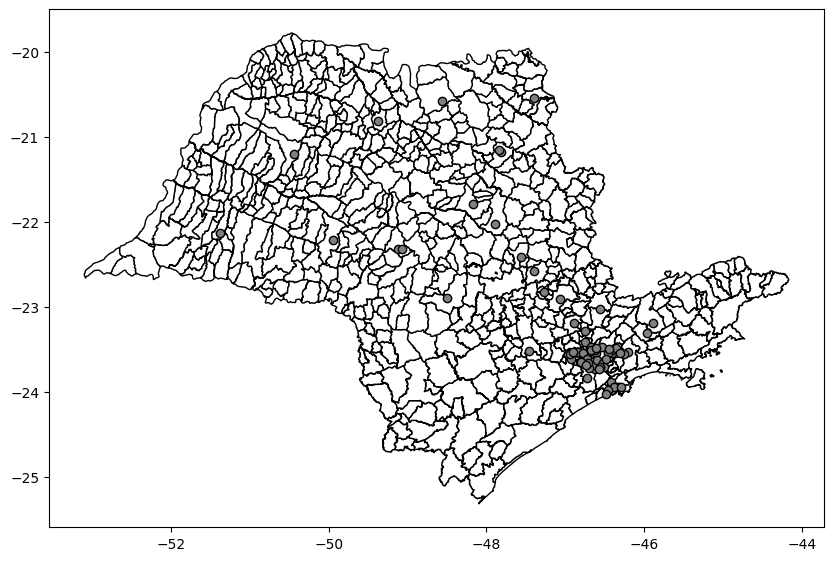

In [29]:
fig, ax = plt.subplots(figsize=(10,8))

# Plotando o mapa dos distritos
cad_unico.plot(ax=ax, color='white', edgecolor='k')

# Plotando os equipamentos esportivos no mesmo ax
bom_prato.plot(ax=ax, color='gray', edgecolor='k')

# # Garantindo que ambos os plots usem os mesmos limites de eixos
# ax.set_xlim(distritos.total_bounds[[0, 2]])  # Definindo limites no eixo x
# ax.set_ylim(distritos.total_bounds[[1, 3]])  # Definindo limites no eixo y

plt.show()

In [ ]:
# Quantos bom prato atende aquele município ?
# Tem que definir o raio, pois pessoas de outro município podem ir para um
# bom prato de outro devido ao raio de distância.